# Export as extrapolated .tsv from Track Attack with all columns

In [7]:
import pandas as pd
from pathlib import Path
from os.path import abspath, dirname, split, splitext
data_path = abspath("data")
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import os
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'
import ipywidgets as widgets
from mpl_toolkits.basemap import Basemap
import numpy as np
from scipy.optimize import least_squares
from tkinter import Tk
from tkinter.filedialog import askopenfilenames
import time
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_rows', 100)

In [16]:
for col in df_import.columns:
    print(col)

Start Date
Start Time
Lap Number
Session Time
Lap Time
Longitude
GPS Distance
GPS Lateral Acceleration
Longitudinal Acceleration
Latitude
GPS Longitudinal Acceleration
Lateral Acceleration
GPS Speed


In [17]:
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
files = askopenfilenames(filetypes=[('TSV','*.tsv')]) # show an "Open" dialog box and return the path to the selected file
for file in files:
    df_import = pd.read_csv(file, delimiter = "\t")
    cols = []
    for col in df_import.columns:
        cols.append(col.replace(' ','_').lower())
    df_import.columns = cols
    min_lat = df_import['latitude'].min() -.01
    max_lat = df_import['latitude'].max() +.01
    min_lon = df_import['longitude'].min() -.01
    max_lon = df_import['longitude'].max() +.01
    
    

40.566806

# Track and Data parameters

# Functions

In [46]:
def corner_assign(lat_column,lon_column,track_config_list, gate=.0004):
    lat_list = lat_column.to_list()
    lon_list = lon_column.to_list()
    corner_dict = {}
    corner_name = []
    corner_num = []
    corner_color = []
    corner = -1
    for i, lon in enumerate(lon_list):
        corner_details = {}
        lat = lat_list[i]
        heading = track_config_list[corner]['heading']
        if corner >= len(track_config_list) -1:
            corner = -1
        c_lon = track_config_list[corner+1]['coord'][1]
        c_lat = track_config_list[corner+1]['coord'][0]
        c_head = track_config_list[corner+1]['heading']
        c_next = track_config_list[corner+1]['corner_name']
        if c_head == "n":
            if lat > c_lat and lon > c_lon - gate and lon < c_lon + gate:
                corner += 1
        elif c_head == "s":
            if lat < c_lat and lon > c_lon - gate and lon < c_lon + gate:
                corner += 1
        elif c_head == "e":
             if lon > c_lon and lat > c_lat - gate and lat < c_lat + gate:
                corner += 1
        elif c_head == "w":
            if lon < c_lon and lat > c_lat - gate and lat < c_lat + gate:
                corner += 1
        corner_name.append(track_config_list[corner]['corner_name'])
        corner_num.append(float(track_config_list[corner]['corner_num']))
        corner_color.append(track_config_list[corner]['color'])
        #print(lat,c_lat,lon,c_lon,c_head,c_next)
    corner_dict['corner_name'] = corner_name
    corner_dict['corner_num'] = corner_num
    corner_dict['corner_color'] = corner_color
    
    return corner_dict

In [47]:
def mph_convert(speed_column, units = 'kph'):
    if units == 'kph':
        speed = speed_column * 0.62137
    else:
        speed = speed_column
    return speed

In [48]:
speed_units = 'kph' #'kph' or 'mph'

In [49]:
def time_conv(time_col):
    seconds_list = []
    minutes_list = []
    for time in time_col.to_list():
        seconds = time/1000000000
        minutes = int(seconds//60)
        remaining_seconds = seconds -minutes*60
        whole_seconds = str(int(remaining_seconds)).zfill(2)
        partial_seconds = str(remaining_seconds%1)[1:5]
        minutes_seconds = "%s:%s%s" % (minutes, whole_seconds, partial_seconds)
        seconds_list.append(seconds)
        minutes_list.append(minutes_seconds)
    times = {'seconds':seconds_list,'minutes':minutes_list}
    return times

In [50]:
#gradient stuff
#https://colordesigner.io/gradient-generator
gradient_colors = ['#6ecafa',
                    '#6dc0fb',
                    '#73b5fa',
                    '#7ea9f7',
                    '#8c9bf0',
                    '#9c8de6',
                    '#ab7ed9',
                    '#b96ec7',
                    '#c45cb3',
                    '#cc499b',
                    '#d03681',
                    '#d02166',
                    '#cb0a49',
                    '#c2002d',
                    '#b4070b']
gradient_count = len(gradient_colors)

def gradient(speed_column,min_speed,max_speed,gradient_list):
    gradient_bucket = (max_speed-min_speed)/gradient_count+.1
    min_bucket = []
    max_bucket = []
    for i,gradient in enumerate(gradient_colors):
        if i == 0:
            min_bucket.append(0)
            max_bucket.append((i+1)*gradient_bucket+min_speed)
        else:
            min_bucket.append(i*gradient_bucket+min_speed)
            max_bucket.append((i+1)*gradient_bucket+min_speed)

    speed_list = speed_column.to_list()
    speed_gradient = []
    for speed in speed_list:
        for i, color in enumerate(gradient_colors):
            if speed < max_bucket[i] and speed >= min_bucket[i]:
                speed_gradient.append(color)
    return speed_gradient

def gradients(data_frame, speed_col,  brake_perc_col, corner_perc_col, accel_perc_col, min_speed,max_speed,unique_nm_col=None):
    speed = data_frame[speed_col].to_list()
    accel_perc = data_frame[accel_perc_col].to_list()
    brake_perc = data_frame[brake_perc_col].to_list()
    corner_perc = data_frame[corner_perc_col].to_list()
    speed_gradient = gradient(data_frame[speed_col],min_speed,max_speed,gradient_colors)
    phase_gradient = []
    min_corner = min(data_frame[corner_perc_col])
    max_corner = max(data_frame[corner_perc_col])
    corner_gradient = gradient(data_frame[corner_perc_col],min_corner,max_corner,gradient_colors)
    min_brake = min(data_frame[brake_perc_col])
    max_brake = max(data_frame[brake_perc_col])
    brake_gradient = gradient(data_frame[brake_perc_col],min_brake,max_brake,gradient_colors)
    min_accel = min(data_frame[accel_perc_col])
    max_accel = max(data_frame[accel_perc_col])
    accel_gradient = gradient(data_frame[accel_perc_col],min_accel,max_accel,gradient_colors)
    gradients = {}
    if unique_nm_col == None:
        max_speed = max(speed)
        max_accel_perc = max(accel_perc)
        max_brake_perc = max(brake_perc)
        max_corner_perc = max(corner_perc)
        s,a,b,c = True,True,True,True
        for i,mph in enumerate(speed):
            if accel_perc[i] >= max_accel_perc *.95:
                a = False
                phase_gradient.append('green')
            elif b and brake_perc[i] == max_brake_perc:
                b = False
                phase_gradient.append('black')
            elif corner_perc[i] >= max_corner_perc*.95:
                c = False
                phase_gradient.append('yellow')
            else:
                phase_gradient.append(speed_gradient[i])
            
    gradients['speed'] = speed_gradient
    gradients['speed_phase'] = phase_gradient
    gradients['corner'] = corner_gradient
    gradients['brake'] = brake_gradient
    gradients['accel'] = accel_gradient
    return gradients          

In [51]:
#plot bound creation
def plot_bounds(lat_column,lon_column,adder = .0001):
    lat_min = lat_column.min()-adder
    lat_max = lat_column.max()+adder
    lon_min = lon_column.min()-adder
    lon_max = lon_column.max()+adder
    return lat_min, lat_max, lon_min, lon_max



In [52]:
#brake percentage
def brake_perc(long_acceleration_col,buffer = .9):
    max_brake = long_acceleration_col.min()*buffer
    accel_list = long_acceleration_col.to_list()
    brake_perc_list = []
    for accel in accel_list:
        if accel < 0:
            brake_perc_list.append(accel/max_brake)
        else:
            brake_perc_list.append(0)
    return brake_perc_list

In [53]:
#cornering percentage
def corner_perc(lat_acceleration_col,buffer = .9):
    max_corner1 = abs(lat_acceleration_col.max())
    max_corner2 = abs(lat_acceleration_col.min())
    max_corner = max(max_corner1,max_corner2)*buffer
    corner_list = lat_acceleration_col.to_list()
    corner_perc_list = []
    for corner in corner_list:
        corner_perc_list.append(abs(corner)/max_corner)
    return corner_perc_list

In [54]:
#robust least squares for max acceleration function
def func(x, t, y):
    return x[0] * np.exp(-x[1] * t) * np.sin(x[2] * t) - y
def generate_data(t, A, sigma, omega, noise=0, n_outliers=0, random_state=0):
    y = A * np.exp(-sigma * t) * np.sin(omega * t)
    rnd = np.random.RandomState(random_state)
    error = noise * rnd.randn(t.size)
    outliers = rnd.randint(0, t.size, n_outliers)
    error[outliers] *= 35
    return y + error
def rlsq(speed_int,long_acceleration):
    x0 = np.ones(3)
    res_robust = least_squares(func, x0, loss='soft_l1', f_scale=0.1, args=(speed_int, long_acceleration))
    t_test = np.linspace(speed_int.min(), speed_int.max()+2, speed_int.max()-speed_int.min()+3)#.astype('int')
    y_robust = generate_data(t_test, *res_robust.x)
    return t_test, y_robust

#func to apply acceleration percentage to raw data
def accel_perc(model_mph,model_accel,speed_int_col,accel_col):
    accel_perc_list = []
    accel_dict = {}
    for i, accel in enumerate(model_accel):
        accel_dict[i] = accel  
    print(accel_dict)
    accel_data = accel_col.to_list()
    for j, speed in enumerate(speed_int_col.to_list()):
        accel_perc_list.append(accel_data[j]/accel_dict[speed])
    return accel_perc_list

#linear regression for more reliable prediction
def lin_reg(df, speed_col,acceleration_col, min_speed = 30):
    df[df[speed_col] >= min_speed]
    numpy_speed = df[speed_col].to_numpy().reshape((-1, 1))
    numpy_acceleration = df[acceleration_col].to_numpy()
    model = LinearRegression().fit(numpy_speed, numpy_acceleration)
    intercept = model.intercept_
    slope = model.coef_[0]
    return intercept, slope

# Data grab and prep

In [55]:
for item in p.iterdir():
    print(item)

/Users/ruggles/repos/racing_data/data/umc_west_jk_5_21_21
/Users/ruggles/repos/racing_data/data/.DS_Store
/Users/ruggles/repos/racing_data/data/umc_east_br_4_23_21
/Users/ruggles/repos/racing_data/data/umc_west_br_5_21_21
/Users/ruggles/repos/racing_data/data/folder_naming.txt
/Users/ruggles/repos/racing_data/data/limerock_chicanes_br_4_15_22


In [63]:
df_dict = {}
meta_dict = {}
p = Path(data_path)
for item in p.iterdir():
    if item.is_dir():
        dir_name = split(item)[1]
        first = True
        meta = {}
        for file in item.iterdir():
            file_name = split(file)[1]
            if splitext(file)[1] == '.tsv':
                if first:
                    df_final = pd.read_csv(file, delimiter = "\t")
                    df_final['file'] = file_name.split('.')[0]
                    first = False
                else:
                    df = pd.read_csv(file, delimiter = "\t")
                    df['file'] = file_name.split('.')[0]
                    df_final = df_final.append(df)
        df_final = df_final.reset_index(drop=True)
        column_names = []
        for nm in df_final.columns:
            column_names.append(column_name_dict[nm.lower()])
        df_final.columns = column_names
        df_final['mph'] = mph_convert(df_final['gps_speed'],speed_units)
        df_dict[dir_name] = df_final
        meta['track'] = dir_name.split("_")[0]
        meta['track_config'] = dir_name.split("_")[1]
        meta['driver'] = dir_name.split("_")[2]
        meta['date'] = dir_name.split("_")[3]
        meta['track_and_config'] = dir_name.split("_")[0] + '-' + dir_name.split("_")[1]
        meta_dict[dir_name] = meta


In [64]:
df_dict.keys()

dict_keys(['umc_west_jk_5_21_21', 'umc_east_br_4_23_21', 'umc_west_br_5_21_21', 'limerock_chicanes_br_4_15_22'])

In [65]:
key = 'limerock_chicanes_br_4_15_22'
race_data = df_dict[key]
#race_data

# Clean out the outliers and add calculated data

In [66]:
std_devs= 5
y_mean = race_data['latitude'].mean()
y_std = race_data['latitude'].std()
x_mean = race_data['longitude'].mean()
x_std = race_data['longitude'].std()
min_std = min(x_std,y_std)
y_bound_low = y_mean - min_std*std_devs
y_bound_high = y_mean + min_std*std_devs
x_bound_low = x_mean - min_std*std_devs
x_bound_high = x_mean + min_std*std_devs
rd_clean = race_data[(race_data.latitude < y_bound_high) & (race_data.latitude > y_bound_low) &
                    (race_data.longitude < x_bound_high) & (race_data.longitude > x_bound_low)]
rd_clean['lap_name'] = rd_clean['file'] + " lap" + rd_clean['lap_number'].astype(str)
rd_clean = rd_clean.copy()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [67]:
#corner widget
corner_name_list = []
corner_num_list = []
for i,item in enumerate(track_configs[meta_dict[key]['track_and_config']]):
    tuple = (item['corner_name'],i)
    corner_name_list.append(tuple)
    corner_num_list.append(i)
corner_select = widgets.SelectMultiple(
    options=corner_name_list,
    value = corner_num_list,
    description='Active Corners',
    rows = len(corner_name_list),
    disabled=False
)
display(corner_select)

KeyError: 'limerock-chicanes'

# Add Calculated data

In [417]:
#make a list of corners
corner_list = []
color = 'red'
for i in corner_select.value:
    if color == 'red':
        track_configs[meta_dict[key]['track_and_config']][i]['color'] = 'red'
        color = 'blue'
    else:
        track_configs[meta_dict[key]['track_and_config']][i]['color'] = 'blue'
        color = 'red'
    corner_list.append(track_configs[meta_dict[key]['track_and_config']][i])
#corners
corners = corner_assign(rd_clean['latitude'],rd_clean['longitude'],corner_list)
rd_clean['corner_name'] = corners['corner_name']
rd_clean['corner_num'] = corners['corner_num']
rd_clean['corner_color'] = corners['corner_color']
rd_clean['lap_corner'] = rd_clean['corner_name'] + "-" + rd_clean['lap_name']
#braking 
rd_clean['brake_perc'] = brake_perc(rd_clean['gps_long_acceleration'])
#cornering
rd_clean['corner_perc'] = corner_perc(rd_clean['gps_lat_acceleration'])
#acceleration
buckets = 3
bucket_mult = 1/buckets
rd_clean['mph_int'] = rd_clean['mph'].astype('int')
rd_clean['pre_mph_bucket'] = rd_clean['mph']*bucket_mult
rd_clean['mph_bucket'] = rd_clean['pre_mph_bucket'].astype('int') 
acceleration = rd_clean.groupby('mph_bucket').agg({'gps_long_acceleration' : 'max',
                                               'mph_int' : 'max'}).reset_index()
accel_filtered = acceleration[acceleration.gps_long_acceleration > 0]
intercept, slope = lin_reg(accel_filtered, 'mph_int','gps_long_acceleration', min_speed = 30)
rd_clean['accel_perc'] = rd_clean['gps_long_acceleration'] / (rd_clean['mph'] * slope + intercept)
#Lap Times and rankings
min_time = 1000000000
max_time = 125000000000
lap_times = rd_clean.groupby('lap_name').agg({'lap_time': 'max'}).reset_index()
lap_times.columns = ['lap_name','lap_time']
lap_filter = lap_times[(lap_times.lap_time > min_time) & (lap_times.lap_time < max_time)]['lap_name'].to_list()
lap_times = lap_times[lap_times.lap_name.isin(lap_filter)]
lap_times['lap_rank'] = lap_times['lap_time'].rank()
lap_times['lap_seconds'] = time_conv(lap_times['lap_time'])['seconds']
lap_times['lap_minutes'] = time_conv(lap_times['lap_time'])['minutes']
#Corner Times, Rankings, Avg Corner Speed
corner_times = rd_clean[rd_clean.lap_name.isin(lap_filter)].groupby('lap_corner').agg(
                        {'lap_time':['min','max'],
                        'mph':['min','max','mean','last'],
                        'corner_name':'min',
                        'brake_perc':'max',
                        'corner_perc':'max',
                        'accel_perc' :'max',
                        'corner_num' :'min'
                        }).reset_index()
corner_times.columns = corner_times.columns.map('_'.join).str.strip('_')
corner_times['corner_time'] = corner_times['lap_time_max'] - corner_times['lap_time_min']
corner_times['corner_seconds'] = time_conv(corner_times['corner_time'])['seconds']
corner_times = corner_times.sort_values(by=['mph_last'], ascending = False)
corner_times['corner_time_rank'] = corner_times.groupby('corner_name_min')['corner_time'].rank(method = 'first')
corner_times = corner_times.sort_values(by=['corner_time'])
corner_times['corner_exit_rank'] = corner_times.groupby('corner_name_min')['mph_last'].rank(ascending = False, method = 'first')

# Widgets

In [383]:
analysis_set = widgets.Dropdown(
    options=['Top 4', 'Top and Bottom'],
    description='Analyze:',
    disabled=False,
)

corner_options = corner_times['corner_name_min'].unique()
corner_nm = widgets.Dropdown(
    options=corner_options,
    description='Corner Name:',
    disabled=False,
)
corner_rank = widgets.Dropdown(
    options=['corner_exit_rank','corner_time_rank'],
    description='Corner rank:',
    disabled=False,
)
gradient_type = widgets.Dropdown(
    options=['speed_phase','speed','corner','brake','accel'],
    description='Gradient Type:',
    disabled=False,
)
internet = widgets.Dropdown(
    options=['online','offline'],
    description='Internet:',
    disabled=False,
)

display(analysis_set)
display(corner_nm)
display(corner_rank)
display(gradient_type)
display(internet)

Dropdown(description='Analyze:', options=('Top 4', 'Top and Bottom'), value='Top 4')

Dropdown(description='Corner Name:', options=('black_rock_hairpin', 'demon', 'dreamboat', 'indecision', 'main_…

Dropdown(description='Corner rank:', options=('corner_exit_rank', 'corner_time_rank'), value='corner_exit_rank…

Dropdown(description='Gradient Type:', options=('speed_phase', 'speed', 'corner', 'brake', 'accel'), value='sp…

Dropdown(description='Internet:', options=('online', 'offline'), value='online')

# Plot Stuff

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-112.381215,40.579041999999994,-112.379195,40.58095&bboxSR=4326&imageSR=4326&size=400,377&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-112.381215,40.579041999999994,-112.379195,40.58095&bboxSR=4326&imageSR=4326&size=400,377&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-112.381215,40.579041999999994,-112.379195,40.58095&bboxSR=4326&imageSR=4326&size=400,377&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-112.381215,40.579041999999994,-112.379195,40.58095&bboxSR=4326&imageSR=4326&size=400,377&dpi=96&format=png32&transparent=true&f=image


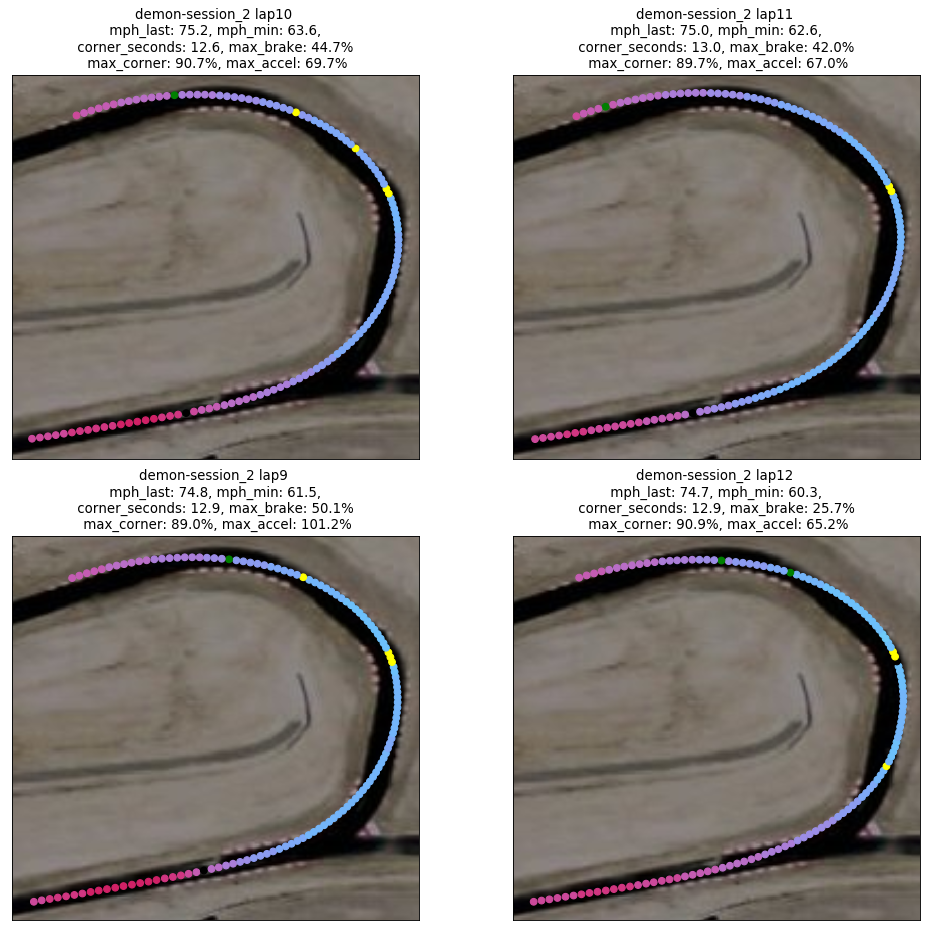

In [392]:
pre_vis_df_list = []
vis_df_list = []
vis_df_meta_list = []
vis_meta_list = []
vis_title_list = []

if analysis_set.value == "Top 4":
    vis_filter = corner_times[(corner_times[corner_rank.value] <=4) & 
                              (corner_times.corner_name_min == corner_nm.value)].sort_values(by=corner_rank.value)['lap_corner'].to_list()
elif analysis_set.value == "Top and Bottom":
    max_rank = corner_times[corner_rank.value].max()
    vis_filter = corner_times[((corner_times[corner_rank.value] <=2) & 
                              (corner_times.corner_name_min == corner_nm.value)) |
                             ((corner_times[corner_rank.value] >= max_rank-1) &
                              (corner_times.corner_name_min == corner_nm.value))
                              ].sort_values(by=corner_rank.value)['lap_corner'].to_list()
for filt in vis_filter:
    vis_df = rd_clean[rd_clean.lap_corner == filt].copy()
    pre_vis_df_list.append(vis_df)
    vis_df_meta = corner_times[corner_times.lap_corner == filt].copy()
    vis_df_meta_list.append(vis_df_meta)
    vis_title_list.append(vis_df_meta['lap_corner'].values[0])
    vis_meta_list.append("mph_last: {:.1f}, mph_min: {:.1f}, \n corner_seconds: {:.1f}, max_brake: {:.1%} \n max_corner: {:.1%}, max_accel: {:.1%}".format( 
                             vis_df_meta['mph_last'].values[0],
                              vis_df_meta['mph_min'].values[0],
                              vis_df_meta['corner_seconds'].values[0],
                              vis_df_meta['brake_perc_max'].values[0],
                              vis_df_meta['corner_perc_max'].values[0],
                              vis_df_meta['accel_perc_max'].values[0]
                              ))   
    
#add gradients
min_speed = pre_vis_df_list[0]['mph'].min()-5
max_speed = pre_vis_df_list[0]['mph'].max()+5
for df in pre_vis_df_list:
    gradient_dict = gradients(df,'mph','brake_perc','corner_perc','accel_perc',min_speed,max_speed)
    df['gradient'] = gradient_dict[gradient_type.value]
    vis_df_list.append(df)

#get map bounds and set parameters for map
lat_min, lat_max, lon_min, lon_max = plot_bounds(vis_df_list[0]['latitude'],vis_df_list[0]['longitude'])
axis_names = [[0,0],[0,1],[1,0],[1,1]]
ratio = 1/((lat_max-lat_min)/(lon_max-lon_min))
size = 14

#start plotting
fig, axs = plt.subplots(2,2, figsize=(size*ratio, size), dpi=80)

for i,axis_names in enumerate(axis_names): 
    data = vis_df_list[i] 
    axs[axis_names[0],axis_names[1]].scatter(data['longitude'],data['latitude'], c=data['gradient'])
    axs[axis_names[0],axis_names[1]].set_title("%s \n %s" % (vis_title_list[i],vis_meta_list[i]))
    if internet.value == 'online':
        map = Basemap(llcrnrlon=lon_min,urcrnrlon=lon_max,llcrnrlat=lat_min,urcrnrlat=lat_max,resolution = 'c', ax = axs[axis_names[0],axis_names[1]])
        map.arcgisimage(service='ESRI_Imagery_World_2D', verbose= True) 
    else:
        axs[axis_names[0],axis_names[1]].set_xlim([lon_min,lon_max])
        axs[axis_names[0],axis_names[1]].set_ylim([lat_min,lat_max])
        axs[axis_names[0],axis_names[1]].xaxis.set_visible(False)
        axs[axis_names[0],axis_names[1]].yaxis.set_visible(False)
    
plt.show() 

# One best lap

In [431]:
optimal_lap_corners = corner_times[corner_times[corner_rank.value] ==1].sort_values(by=['corner_num_min'])['lap_corner'].to_list()
optimal_lap_corners
for i, corner in enumerate(optimal_lap_corners):
    if i ==0:
        optimal_lap_data = rd_clean[rd_clean.lap_corner == corner]
    else:
        optimal_lap_data = optimal_lap_data.append(rd_clean[rd_clean.lap_corner == corner])

seconds = len(optimal_lap_data)/10
minutes = int(seconds//60)
remaining_seconds = seconds -minutes*60
whole_seconds = str(int(remaining_seconds)).zfill(2)
partial_seconds = str(remaining_seconds%1)[1:5]
minutes_seconds = "%s:%s%s" % (minutes, whole_seconds, partial_seconds)
print(minutes_seconds)

1:51.599


# Map and Plot

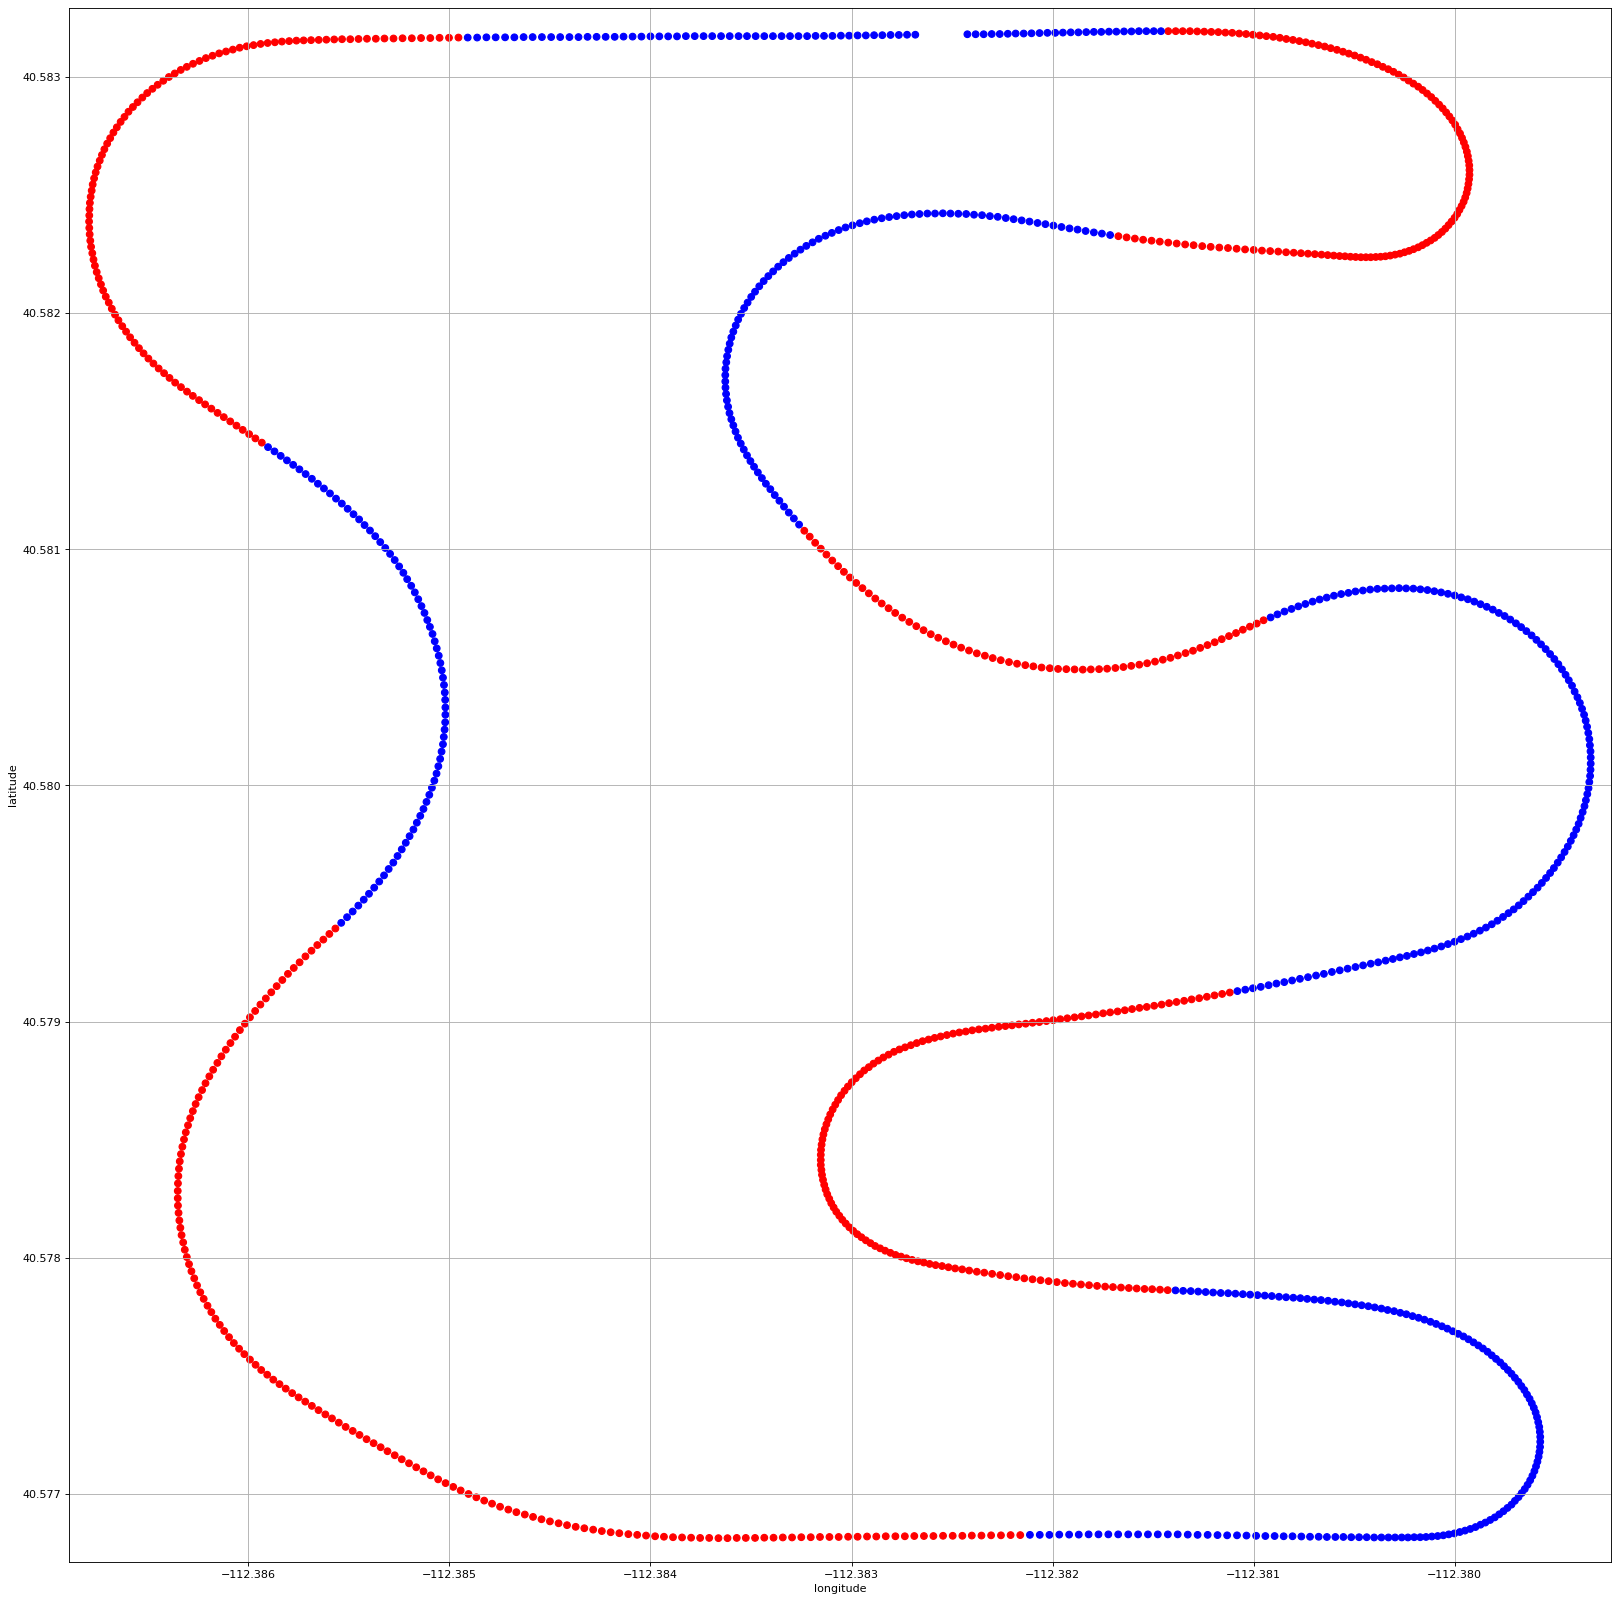

In [433]:
#prep data
one_lap_filter = lap_times[lap_times.lap_rank == 1]['lap_name'].values[0]
one_lap = rd_clean[rd_clean.lap_name == one_lap_filter].copy()
lat_min, lat_max, lon_min, lon_max = plot_bounds(one_lap['latitude'],one_lap['longitude'])
#plot it
plt.figure(figsize=(20, 20), dpi=80)
plt.grid(which='both')
plt.tight_layout()
plt.xlim([lon_min,lon_max])
plt.ylim([lat_min,lat_max])
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ticklabel_format(useOffset=False)
plt.title ='test'
plt.scatter(one_lap['longitude'],one_lap['latitude'], c=one_lap['corner_color']);